In [1]:
import numpy as np
import pandas as pd
from cmaes import CMA
from sklearn import linear_model
from sklearn.metrics import roc_auc_score
from pathlib import Path
from matplotlib import pyplot as plt

/Users/teppei/.local/share/virtualenvs/SETI-rgkZMqMW/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
expts = [
    "efficientnetb0_100epoch",
    "efficientnetv2s_100epoch",
    "mobilenet100-100epoch",
    "nfnet_l0",
    "resnet18-18epoch",
    "resnext50-75epoch",
    "efficientnetv2s_640",
    "rexnet",
    "tf_efficientnet_b1_ns"
]

tta = [
    "",
    "tta_mean_",
    "tta_max_",
    "tta_min_",
    "tta_gmean_"
]

expts

basedir = Path('.').resolve()

In [19]:
# read oof

train_df = pd.read_csv(basedir.parent / 'seti-breakthrough-listen' / 'train_labels.csv')

folds = list()
for _expt in expts:
    for _tta in tta:  
        _df = pd.read_csv(basedir / _expt / 'output' / f'{_tta}oof_prediction.csv')
        _df = _df.set_index('id')
        train_df[f'{_expt}_{_tta}'] = train_df.id.map(_df['target'])
        folds.append(_df['fold'].values)
    
assert all(np.all(folds[0] == _fold) for _fold in folds)

train_df['fold'] = folds[0]
# train_df.to_csv('./oof_prediction.csv')

In [20]:
# read test

test_df = pd.read_csv(basedir.parent / 'seti-breakthrough-listen' / 'sample_submission.csv')

for _expt in expts:
    for _tta in tta:
        _df = pd.read_csv(basedir / _expt / 'output' / f'{_tta}submission.csv')
        _df = _df.set_index('id')
        test_df[f'{_expt}_{_tta}'] = test_df.id.map(_df['target'])
# test_df.to_csv('./test_prediction.csv')

In [28]:
feature_cols = test_df.drop(columns=['id', 'target']).columns
# only tta_mean
feature_cols = [f for f in feature_cols if 'tta_mean' in f]
feature_cols

['efficientnetb0_100epoch_tta_mean_',
 'efficientnetv2s_100epoch_tta_mean_',
 'mobilenet100-100epoch_tta_mean_',
 'nfnet_l0_tta_mean_',
 'resnet18-18epoch_tta_mean_',
 'resnext50-75epoch_tta_mean_',
 'efficientnetv2s_640_tta_mean_',
 'rexnet_tta_mean_',
 'tf_efficientnet_b1_ns_tta_mean_']

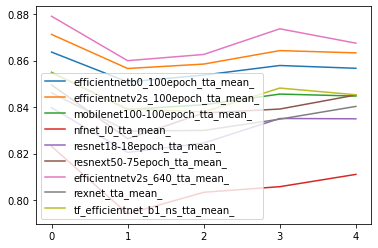

In [31]:
scores = dict()

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

for f in feature_cols:
    y = list()
    for _fold in range(5):
        pred, target = train_df[_fold == train_df.fold][[f, 'target']].values.T
        y.append(roc_auc_score(target, pred))
    ax.plot(y, label=f)
    scores[f] = y
ax.legend()
ax.set_xticks(range(5))

# average
scores['average'] = list()
for _fold in range(5):
    _df = train_df[train_df.fold == _fold]
    target = _df['target'].values
    pred = _df[feature_cols].mean(axis=1).values
    pred = np.clip(pred, 0, 1)
    scores['average'].append(roc_auc_score(target, pred))

In [34]:
scores['efficientnetv2s_640_tta_mean_'], scores['average']

([0.8790613811728394,
  0.8599518518518519,
  0.8626253472222223,
  0.8736616126543209,
  0.8674788194444446],
 [0.8712586419753087,
  0.8604948302469135,
  0.8588276234567901,
  0.8678432098765432,
  0.8654735339506172])

## average 

In [35]:
pred = test_df[feature_cols].mean(axis=1).values
pred = np.clip(pred, 0, 1)

submission_df = test_df[['id', 'target']].copy()
submission_df['target'] = pred
submission_df.head()

,id,target
0,000bf832cae9ff1,0.077678
1,000c74cc71a1140,0.098577
2,000f5f9851161d3,0.079185
3,000f7499e95aba6,0.121962
4,00133ce6ec257f9,0.086368


In [36]:
submission_df.to_csv('submission.csv', index=False)

## CMA :whole data

In [37]:
train_df

,id,target,efficientnetb0_100epoch_,efficientnetb0_100epoch_tta_mean_,efficientnetb0_100epoch_tta_max_,efficientnetb0_100epoch_tta_min_,efficientnetb0_100epoch_tta_gmean_,efficientnetv2s_100epoch_,efficientnetv2s_100epoch_tta_mean_,efficientnetv2s_100epoch_tta_max_,...,rexnet_tta_mean_,rexnet_tta_max_,rexnet_tta_min_,rexnet_tta_gmean_,tf_efficientnet_b1_ns_,tf_efficientnet_b1_ns_tta_mean_,tf_efficientnet_b1_ns_tta_max_,tf_efficientnet_b1_ns_tta_min_,tf_efficientnet_b1_ns_tta_gmean_,fold
0,0000799a2b2c42d,0,0.070504,0.077875,0.099301,0.070504,0.076993,0.073593,0.087585,0.123840,...,0.070493,0.073558,0.067210,0.070434,0.078649,0.097540,0.147209,0.078649,0.093995,4
1,00042890562ff68,0,0.054310,0.054239,0.060177,0.049736,0.054108,0.064106,0.062802,0.065819,...,0.080323,0.093636,0.064421,0.079614,0.059791,0.061845,0.073025,0.054735,0.061493,2
2,0005364cdcb8e5b,0,0.040747,0.048061,0.055445,0.040747,0.047661,0.046730,0.049359,0.053314,...,0.075420,0.084975,0.062966,0.074957,0.054372,0.055771,0.059819,0.049772,0.055621,2
3,0007a5a46901c56,0,0.043856,0.042029,0.048013,0.036040,0.041795,0.051743,0.058143,0.094224,...,0.052278,0.059134,0.045682,0.052058,0.046356,0.045217,0.046490,0.042003,0.045177,4
4,0009283e145448e,0,0.057626,0.055830,0.059212,0.052709,0.055766,0.039957,0.039745,0.043515,...,0.066348,0.070983,0.063914,0.066293,0.049388,0.055113,0.062235,0.049388,0.054917,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,fff8217fe05aba3,0,0.028770,0.027684,0.028770,0.026584,0.027671,0.028428,0.028026,0.030894,...,0.041115,0.090035,0.023147,0.034193,0.029573,0.030256,0.036488,0.026469,0.030036,4
59996,fffa939e610ed70,0,0.040893,0.042424,0.043800,0.040893,0.042411,0.055385,0.054300,0.066501,...,0.052946,0.063617,0.044041,0.052430,0.033554,0.041894,0.049443,0.033554,0.041490,1
59997,fffbb1c9c3d6c31,1,0.837317,0.840088,0.849621,0.836094,0.840070,0.923207,0.943565,0.954545,...,0.829217,0.839676,0.808518,0.829127,0.922983,0.945125,0.976201,0.922983,0.944929,2
59998,fffc9a763d23647,0,0.072558,0.082447,0.103757,0.068818,0.081380,0.114324,0.074957,0.114325,...,0.045015,0.050330,0.041920,0.044908,0.066243,0.072836,0.103051,0.053609,0.070744,4


In [48]:
def objective(x):
    df = train_df
    pred = np.dot(df[feature_cols].values, x)
    pred = np.clip(pred, 0, 1)
    target = df['target'].values
    return roc_auc_score(target, pred)


def softmax(x):
    f_x = np.exp(x) / np.sum(np.exp(x))
    return f_x

In [59]:
def optimize(sigma, n_iters):
    weights = np.ones(len(feature_cols)) / len(feature_cols)

    optimizer = CMA(mean=weights, sigma=sigma)

    best = 0
    best_w = None
    for generation in range(n_iters):
        solutions = []
        for _ in range(optimizer.population_size):
            x = optimizer.ask()
            w = softmax(x)
            value = objective(w)
            solutions.append((x, -value))
            if best < value:
                best = value
                best_w = w
                print(f"#{generation} {np.round(value, 5)} {np.round(best_w, 3)}")
        optimizer.tell(solutions)
    
    return best, best_w

In [60]:
results1 = list()
for i in range(5):
    best_value, best_weights = optimize(sigma=1.3, n_iters=300)
    results1.append((best_value, best_weights))

#0 0.86729 [0.086 0.049 0.153 0.109 0.231 0.018 0.281 0.014 0.059]
#1 0.87067 [0.019 0.06  0.077 0.022 0.133 0.002 0.643 0.002 0.042]
#1 0.87248 [0.1   0.174 0.046 0.039 0.07  0.007 0.541 0.005 0.018]
#6 0.87299 [0.301 0.107 0.05  0.006 0.004 0.002 0.524 0.    0.006]
#11 0.87318 [0.27  0.131 0.031 0.006 0.005 0.    0.553 0.001 0.003]
#12 0.87329 [0.173 0.18  0.022 0.001 0.002 0.    0.616 0.    0.006]
#12 0.87336 [0.177 0.249 0.029 0.007 0.004 0.001 0.533 0.    0.001]
#17 0.87339 [0.24  0.237 0.001 0.003 0.001 0.    0.514 0.    0.004]
#20 0.8734 [0.149 0.277 0.003 0.003 0.002 0.    0.558 0.    0.009]
#21 0.87341 [0.22  0.226 0.007 0.003 0.003 0.    0.538 0.    0.003]
#22 0.87343 [0.2   0.247 0.008 0.004 0.002 0.    0.537 0.    0.001]
#29 0.87344 [0.188 0.26  0.002 0.003 0.002 0.    0.543 0.    0.002]
#36 0.87345 [0.184 0.248 0.003 0.    0.    0.    0.564 0.    0.001]
#39 0.87345 [0.173 0.272 0.005 0.    0.    0.    0.549 0.    0.   ]
#43 0.87345 [0.195 0.25  0.004 0.    0.001 0.    0.55

In [70]:
np.round(np.vstack([r[1] for r in results1]).mean(axis=0), 3)

array([0.189, 0.263, 0.   , 0.   , 0.   , 0.   , 0.548, 0.   , 0.   ])

In [73]:
results2 = list()
for i in range(5):
    best_value, best_weights = optimize(sigma=0.5, n_iters=300)
    results2.append((best_value, best_weights))

#0 0.86151 [0.123 0.072 0.165 0.078 0.122 0.222 0.067 0.054 0.097]
#0 0.86396 [0.187 0.093 0.11  0.09  0.127 0.11  0.089 0.12  0.073]
#0 0.86491 [0.103 0.059 0.153 0.119 0.079 0.139 0.147 0.119 0.082]
#0 0.86632 [0.205 0.098 0.044 0.177 0.061 0.094 0.146 0.123 0.052]
#0 0.86845 [0.08  0.053 0.079 0.086 0.086 0.08  0.3   0.116 0.121]
#1 0.86885 [0.155 0.04  0.044 0.059 0.081 0.045 0.288 0.144 0.145]
#1 0.8706 [0.099 0.038 0.064 0.04  0.042 0.137 0.451 0.059 0.071]
#2 0.87096 [0.114 0.024 0.039 0.024 0.041 0.062 0.507 0.028 0.162]
#3 0.87115 [0.152 0.042 0.021 0.024 0.029 0.107 0.452 0.048 0.124]
#3 0.87165 [0.135 0.037 0.028 0.058 0.019 0.039 0.536 0.024 0.125]
#4 0.87209 [0.15  0.024 0.026 0.017 0.016 0.013 0.712 0.018 0.024]
#5 0.8722 [0.194 0.036 0.061 0.03  0.02  0.018 0.547 0.052 0.043]
#5 0.87229 [0.184 0.029 0.012 0.012 0.029 0.01  0.702 0.013 0.01 ]
#6 0.8723 [0.23  0.008 0.007 0.033 0.008 0.004 0.689 0.018 0.003]
#7 0.87248 [0.275 0.023 0.054 0.021 0.009 0.004 0.571 0.041 0.003

In [74]:
np.round(np.vstack([r[1] for r in results2]).mean(axis=0), 3)

array([0.189, 0.263, 0.   , 0.   , 0.   , 0.   , 0.548, 0.   , 0.   ])

In [54]:
weights = np.ones(len(feature_cols)) / len(feature_cols)
print(objective(weights))
weights = np.array([0., 0., 0., 0., 0., 0., 1., 0., 0.])
print(objective(weights))

0.864471700617284
0.8678838595679013


In [ ]:
# weighted combination
weights = np.array([0.189, 0.263, 0.   , 0.   , 0.   , 0.   , 0.548, 0.   , 0.   ])

pred = test_df[feature_cols].values
pred = np.dot(pred, weights)
pred = np.clip(pred, 0, 1)

submission_df = test_df[['id', 'target']].copy()
submission_df['target'] = pred
submission_df.to_csv('submission.csv', index=False)
submission_df.head()

,id,target
0,000bf832cae9ff1,0.118870
1,000c74cc71a1140,0.143420
2,000f5f9851161d3,0.115490
3,000f7499e95aba6,0.180301
4,00133ce6ec257f9,0.127859


In [3]:
sub_lb = pd.read_csv('./submission_pl0.767.csv')
sub_lb['target'] = np.clip(sub_lb['target'], 0, 1)
my_sub = pd.read_csv('./my_submission_pl0.767.csv')

submission_df = sub_lb.merge(my_sub, on='id')
submission_df['target'] = submission_df['target_x'] * 0.8 + submission_df['target_y'] * 0.2
submission_df['target'] = np.clip(submission_df['target'], 0, 1)
submission_df = submission_df[['id', 'target']]
submission_df.to_csv('submission.csv', index=False)
submission_df.head()

,id,target
0,000bf832cae9ff1,0.057114
1,000c74cc71a1140,0.086642
2,000f5f9851161d3,0.067890
3,000f7499e95aba6,0.191914
4,00133ce6ec257f9,0.066405
